In [1]:
import os
import cartopy
import datetime
import shapely

import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gp

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.lines import Line2D      
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

In [2]:
# Load TE data 
src = rio.open("../results/bf_te/merged/prcp.tiff")
prcp= src.read(1)
prcp[prcp==src.nodata] = np.nan

src = rio.open("../results/bf_te/merged/smlt.tiff")
smlt = src.read(1)
smlt[smlt==src.nodata] = np.nan

# min max normalization 
def normalize(arr):

    return (arr - np.nanmin(arr)) / (np.nanmax(arr) - np.nanmin(arr))

dom_arr_te = normalize(smlt) - normalize(prcp)

# Load XC data 
src = rio.open("../results/BF_xc_K180/merged/prcp.tiff")
prcp= src.read(1)
prcp[prcp==src.nodata] = np.nan

src = rio.open("../results/BF_xc_K180/merged/smlt.tiff")
smlt = src.read(1)
smlt[smlt==src.nodata] = np.nan

dom_arr_xc = normalize(smlt) - normalize(prcp)

dom_arr = dom_arr_xc + dom_arr_te

/var/folders/py/9t078qzs52x65tkpvg23_4mc0000gn/T/ipykernel_54139/2884742303.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  def plot_basemaps(image, shp, title = None, cmap = plt.cm.get_cmap('plasma'), ax = None, latlabels = True, lonlabels = True):
/Users/aakashahamed/anaconda3/envs/wt_env/lib/python3.9/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/aakashahamed/anaconda3/envs/wt_env/lib/python3.9/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/aakashahamed/anaconda3/envs/wt_env/lib/python3.9/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


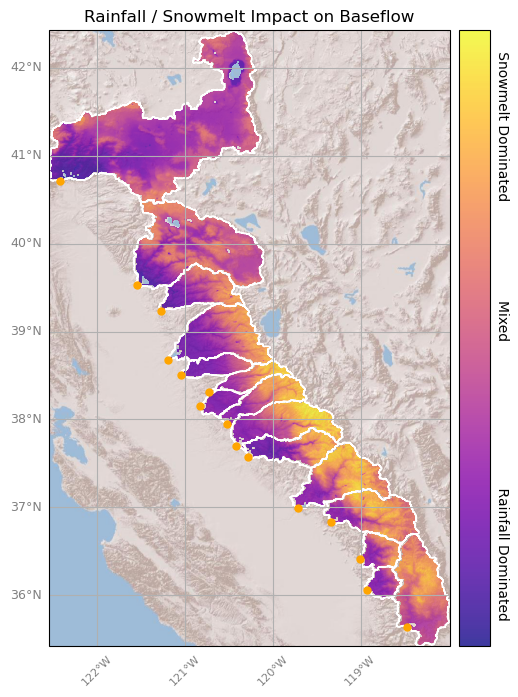

In [3]:
def plot_basemaps(image, shp, title = None, cmap = plt.cm.get_cmap('plasma'), ax = None, latlabels = True, lonlabels = True):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).total_bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')

    minx, miny, maxx, maxy = imextent
    lllon, lllat = minx, miny
    urlon, urlat = maxx, maxy

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.GoogleTiles(style='terrain', url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
    
    gl.xlocator = mticker.FixedLocator([-122,-121,-120,-119])
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'rotation': 45}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)

    # Plot image
    im = ax.imshow(image,
        cmap=cmap, zorder=2, 
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    cbar = fig.colorbar(im, pad=0.01); 
    tick_labels = ['            Rainfall Dominated',
                   '                Mixed',
                   '      Snowmelt Dominated']

    #legend
    # cbar.ax.get_yaxis().set_ticks([])
    yticks = np.linspace(*cbar.ax.get_ylim(), 4)[1:]
    cbar.set_ticks(yticks, labels= tick_labels, rotation= 270)
    cbar.ax.tick_params(size=0) # remove ticks 
    
    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    points = list(Reader("../shape/trm_res_fnf.shp").geometries())

    ax.scatter([point.x for point in points],
               [point.y for point in points],
               transform=ccrs.PlateCarree(), color= 'orange', s = 25, zorder = 10)
        
    # Set the title
    ax.set_title("{}".format(title), size = 12)

    return im


fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
im = plot_basemaps(dom_arr, "../shape/sierra_catchments.shp", "Rainfall / Snowmelt Impact on Baseflow", ax = axes, latlabels = True, lonlabels = True)
fig.subplots_adjust(wspace=-0.02,hspace =0.00)

plt.show()


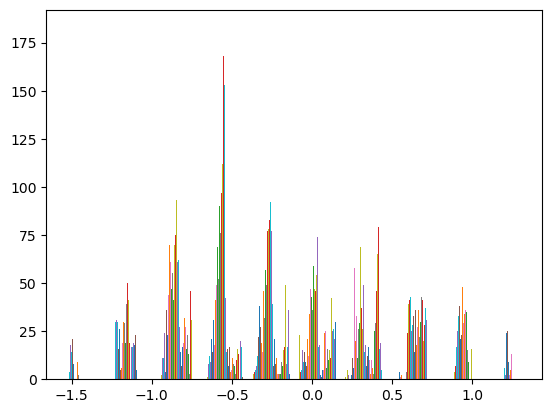

In [4]:
plt.hist(dom_arr); plt.show()